# Memory Based Collaborative Filtering Recommender

The goal of the **recommender system** is to predict user preference for a set of items based on past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.

**Collaborative filtering** is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.

**Memory based algorithms** apply statistical techniques to the entire dataset to calculate the predictions. They can be divided into two main sections: user-item filtering and item-item filtering. The closest user or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are only based on arithmetic operations.

The goal of this exercise is to compare user-item and item-item approach, try different configurations of parameters, optimize model performance and explore obtained results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import functions as f

This analysis will focus on book recommendations based on [Book-Crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). To reduce the dimensionality of the dataset and avoid running into memory error it will focus on users with at least 3 ratings and top 10% most frequently rated books. It consists of 176,594 records.

The recommender systems will be built using [surprise package](https://surprise.readthedocs.io/en/stable/getting_started.html#getting-started) (KNN-based models).

In [2]:
df = pd.read_csv('data/ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [3]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(df), len(df['isbn'].unique()), len(df['user_id'].unique())))

Number of ratings: 176594
Number of books: 16766
Number of users: 20153


## KNN Model Selection

K-Nearest Neighbours algorithm calculates the distances between users or items and finds the closest ones = the most similar ones. Surprise package offers several variations of the model. The comparison of those models shows that KNNBaseline model gives the best performance in terms of RMSE error but it is the most time-consuming when it comes to training (and testing).

In [5]:
models1 = f.generate_models_dict([KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline], ['msd'], True)
results1 = f.cv_multiple_models(data, models1)
display(results1)


---> CV for KNNBasic msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithZScore msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity

fit_time              model  test_mae  test_rmse  test_time
0  11.945322       KNNBasic msd  1.485301   1.939152   1.599797
1  12.236100   KNNWithMeans msd  1.352903   1.807844   1.588807
2  10.513621  KNNWithZScore msd  1.336548   1.803514   1.700801
3  12.615087    KNNBaseline msd  1.349201   1.775448   1.894335

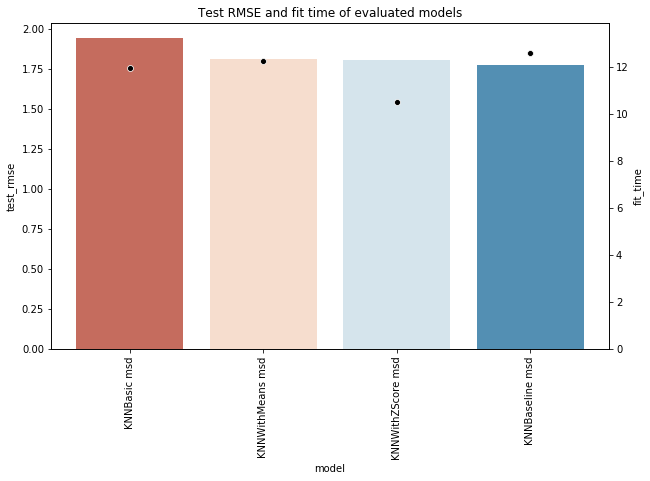

In [6]:
f.draw_model_results(results1)

Which KNN model to choose?

**The best MAE score** KNN with Z score - slightly better than KNN with Means but it takes more time to fit & test this model. It's calculation formula is more complicated thus it's better to choose KNN with Means.

**The best RMSE score** KNN Baseline - the longest fit and test time.

It seems reasonable to choose KNN with Means for further analysis.

## User-Item Model Selection

User-Item approach is to determine a set of the most similar users to the user U (based on their past ratings) and to calculate the rating for the item I based on the ratings assigned by those users.

In [7]:
models2 = f.generate_models_dict([KNNWithMeans], ['cosine', 'msd', 'pearson'], True)
results2 = f.cv_multiple_models(data, models2)
display(results2)


---> CV for KNNWithMeans cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans pearson...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


fit_time                 model  test_mae  test_rmse  test_time
0  26.378158   KNNWithMeans cosine  1.359165   1.812499   4.613726
1  18.967154      KNNWithMeans msd  1.365662   1.824978   4.429326
2  48.865541  KNNWithMeans pearson  1.324715   1.770797   4.797907

## Item-Item Model Selection

Item-Item approach is to determine a set of the most similar items to the item I (based on the past ratings of other users) and to calculate the rating for the item I based on the ratings of similar items rated by the user U.

In [8]:
models3 = f.generate_models_dict([KNNWithMeans], ['cosine', 'msd', 'pearson'], False)
results3 = f.cv_multiple_models(data, models3)
display(results3)


---> CV for KNNWithMeans cosine...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans pearson...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


fit_time                 model  test_mae  test_rmse  test_time
0  34.700298   KNNWithMeans cosine  1.377890   1.820497   9.521478
1  17.180137      KNNWithMeans msd  1.390995   1.839028   9.424307
2  62.453275  KNNWithMeans pearson  1.413463   1.843185   9.728086

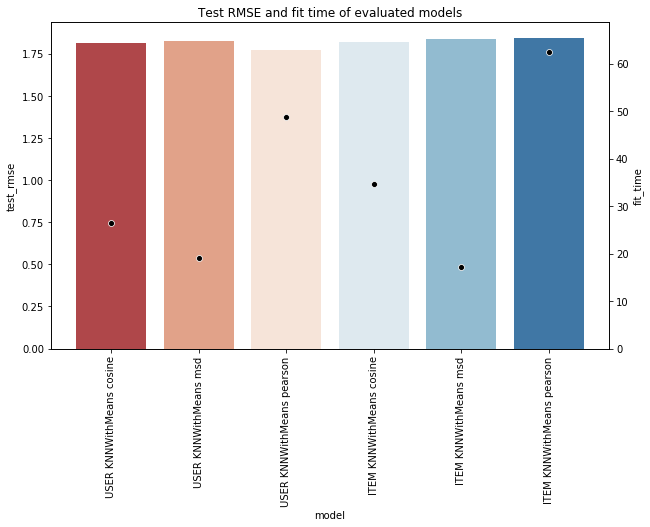

In [9]:
results2['model'] = 'USER ' + results2['model']
results3['model'] = 'ITEM ' + results3['model']

f.draw_model_results(pd.concat([results2, results3]))

## Memory Based Model Optimisation

In [11]:
param_grid = {'k': [30,40,45],
              'min_k': [1,3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#1.7144841610870258
#{'k': 60, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': False}}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

## Analysis of results

In [7]:
trainset, testset = train_test_split(data, test_size=0.2)

sim_options = {
    'name': 'cosine',
    'user_based': False
}

model = KNNWithMeans(sim_options=sim_options)
model.fit(trainset)
predictions = model.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [8]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['k'] = df_pred['details'].apply(f.k_from_details)
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

user_id        isbn  actual_rating  pred_rating   k  impossible  \
15792   261829  0671038443            8.0     7.592099  25       False   
4561     33822  0553277472            6.0     7.638298   0       False   
17282   168816  0385296495            9.0     6.319878   3       False   
7003    102647  0061000043            7.0     7.079520  31       False   
3974     56554  0373250312            9.0     7.717730  17       False   

       pred_rating_round   abs_err  
15792                8.0  0.407901  
4561                 8.0  1.638298  
17282                6.0  2.680122  
7003                 7.0  0.079520  
3974                 8.0  1.282270

### Distribution of actual and predicted ratings in the test set

According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable.
The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent.

It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

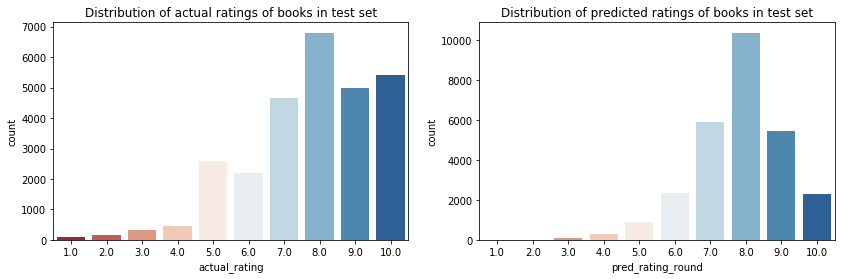

In [88]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

### Absolute error of predicted ratings

The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 0.5. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.

How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations. 

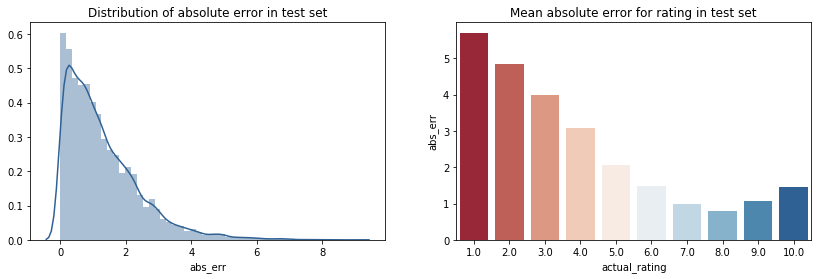

In [89]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [97]:
df_books = pd.read_csv('data/books.csv')

df_pred_ext = df_pred.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_pred_ext['book_title_short'] = df_pred_ext['book_title'].apply(f.short_title)

user_id        isbn  actual_rating  pred_rating     k  impossible  \
0   249862  0671793489           10.0     8.690539    21       False   
1   102647  0515109509            8.0     6.693678     9       False   
2   191795  0765340747            9.0     7.764836  1000        True   
3    47465  0446611867           10.0     7.116393     2       False   
4    97493  0316602051           10.0     6.848680     2       False   

   pred_rating_round   abs_err  \
0                9.0  1.309461   
1                7.0  1.306322   
2                8.0  1.235164   
3                7.0  2.883607   
4                7.0  3.151320   

                                         book_title  \
0                               All Around the Town   
1                      The Cat Who Moved a Mountain   
2  The Pillars of Creation (Sword of Truth, Book 7)   
3                                A Bend in the Road   
4                                        The Jester   

                           book_title_short  
0                       All Around the Town  
1              The Cat Who Moved a Mountain  
2  The Pillars of Creation (Sword of Truth,  
3                        A Bend in the Road  
4                                The Jester

### Analysis of predicted ratings of a particular user

For this part of the analysis, the user with id 246311 was selected. It can be noted that his rating behaviour is slightly different than the behaviour shown in scores' distribution of the whole population. He gives high scores often (7-10) and rating = 10 is the most frequent value.

The distribution of predicted book ratings for this user differs a lot from the actual one. All predicted ratings are between 7-10 (which shows that the model is mistaken for several observations with lower scores) and the most frequent rating is 8 (which implies that probably some of the observations with the real score = 10 have predicted rating lower than actual).

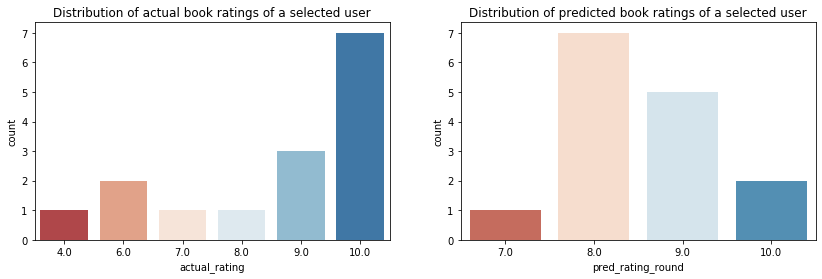

In [101]:
# Selected user: 246311
selected_user_id = 246311

df_pred_user = df_pred_ext[df_pred_ext['user_id']==selected_user_id]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['actual_rating'].unique())), ax=ax1)
ax1.set_title('Distribution of actual book ratings of a selected user')

sns.countplot(x='pred_rating_round', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['pred_rating_round'].unique())), ax=ax2)
ax2.set_title('Distribution of predicted book ratings of a selected user')

plt.show()

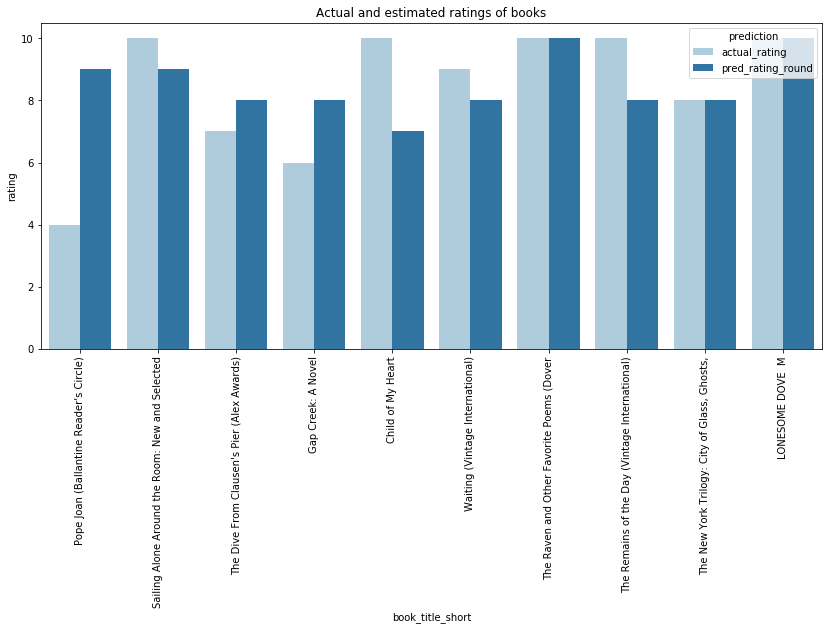

In [112]:
df_pred_sample = df_pred_user[df_pred_user['pred_rating_round'].notna()].sample(10)
df_pred_sample = pd.melt(df_pred_sample[['book_title_short', 'actual_rating', 'pred_rating_round']], id_vars='book_title_short', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x='book_title_short', y='rating', hue='prediction', data=df_pred_sample, palette=sns.color_palette("Paired"))
ax.set_title('Actual and estimated ratings of books')
plt.xticks(rotation=90)

plt.show()